In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import load_configs
from train import train
from models.pixel_rnn import PixelRNN

configs = load_configs("../configs.json")

In [2]:
model = PixelRNN(hidden_dim=64, num_layers=7)

optimizer = Adam(model.parameters())
loss_fn = lambda x,y: x
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((0, 1, 0, 0)) # left, top, right, bottom
])

epochs = 30
batch_size = 128
n_plots = 64

root = configs["dataset_path"]

download = not os.path.exists(os.path.join(root,"MNIST"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

trainset = datasets.MNIST(root=root, download=download, train=True, transform=transform)
testset = datasets.MNIST(root=root, download=download, train=False, transform=transform)

trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=False, batch_size=batch_size)

train(
    model,
    trainloader,
    testloader,
    epochs,
    optimizer,
    loss_fn,
    device,
    data_type="image",
    preprocessing=None,
    additional_eval=None,
    index_type=None,
    save_dir="..",
    n_plots=n_plots
)

30/30 epochs: 100%|██████████| 469/469 [03:28<00:00,  2.25it/s, train_loss=0.0984, test_loss=0.0943]


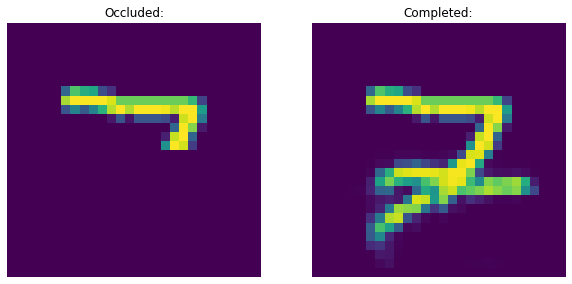

In [3]:
import matplotlib.pyplot as plt

img = torch.FloatTensor(testset.data[0]/255)[None,None,:,:].to(device)
img[:,:,14:,:].zero_()

plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
ax.imshow(img[0,0].cpu().numpy())
ax.set_title("Occluded:")
ax.axis("off")
ax = plt.subplot(1,2,2)
ax.imshow(model.generate(img[:,:,:14,:])[0,0].detach().cpu().numpy())
ax.set_title("Completed:")
_ = ax.axis("off")